In [2]:
!git clone https://github.com/khan496/Track

Cloning into 'Track'...
remote: Enumerating objects: 15325, done.
remote: Total 15325 (delta 0), reused 0 (delta 0), pack-reused 15325
Receiving objects: 100% (15325/15325), 221.52 MiB | 11.10 MiB/s, done.
Checking out files: 100% (15322/15322), done.


In [3]:
!ls Track

driving_log.csv  IMG


In [4]:
!pip3 install imgaug #imgaug is a library for img augmentation in machine learning experiments.

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath #separate the desktop path and image file name
import random

Using TensorFlow backend.


In [6]:
datadir = 'Track' 
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns) #load the data from the csv file by specifying its path for which os needs to be used. List of column names to be used will also be specified above
pd.set_option('display.max_colwidth', -1) #this will display the entire name of the image at any column instead of showing ...  
data.head() #Shows the first five rows in the csv file
# We will have to manipulate images to load the steering data for which the C: root extension that points to the desktop will have to be separated from the image file name(Done below)

center  ...     speed
0  C:\Users\khana\Desktop\self driving cars\Data\IMG\center_2019_12_22_06_44_15_380.jpg  ...  0.000078
1  C:\Users\khana\Desktop\self driving cars\Data\IMG\center_2019_12_22_06_44_15_484.jpg  ...  0.000078
2  C:\Users\khana\Desktop\self driving cars\Data\IMG\center_2019_12_22_06_44_15_585.jpg  ...  0.000078
3  C:\Users\khana\Desktop\self driving cars\Data\IMG\center_2019_12_22_06_44_15_689.jpg  ...  0.000080
4  C:\Users\khana\Desktop\self driving cars\Data\IMG\center_2019_12_22_06_44_15_795.jpg  ...  0.000078

[5 rows x 7 columns]

In [7]:
def path_leaf(path):
  head, tail = ntpath.split(path) #separate the C: ext and the image file name
  return tail
#apply the above function to the entire data
data['center'] = data['center'].apply(path_leaf) #Take every single value of the series and only return the tail end of its path
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head() #show the data

center  ...     speed
0  center_2019_12_22_06_44_15_380.jpg  ...  0.000078
1  center_2019_12_22_06_44_15_484.jpg  ...  0.000078
2  center_2019_12_22_06_44_15_585.jpg  ...  0.000078
3  center_2019_12_22_06_44_15_689.jpg  ...  0.000080
4  center_2019_12_22_06_44_15_795.jpg  ...  0.000078

[5 rows x 7 columns]

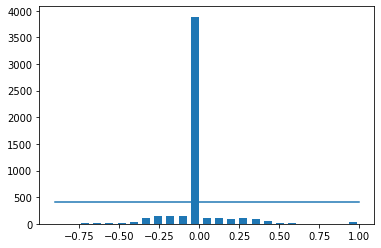

In [8]:
#Plot the steering angles on a histogram to visualise their distribution and see which steering angles are the most frequent in our recording
#This is important to visualise the flaw in our data and analyse the correction steps required during preprocessing
num_bins = 25 #divide the range into intervals. Bin the range of values and make sure it is an odd number to center the distribution
samples_per_bin = 400 #A threshold can be set to reject samples above a certain number of zero angles
hist, bins = np.histogram(data['steering'], num_bins) #access the steering data from the dataframe and divide it into the bins specified
#The above line will return the values of histogram itself and the interval in which the data of steering angle is distributed
center = (bins[:-1]+ bins[1:]) * 0.5 #To center the histogram around 0, perform an element wise addition from the starting to second last elem with second to last elem
#adjacent values will be added to center around 0 and to restore the value which gets doubled multiply it by 0.5
# Most of the angles are around zero degree which can bias the model to only favor near 0 deg angles. A threshold can be set to reject samples above a certain number of zero angles
plt.bar(center, hist, width=0.05) #Plot the bar graph consisting of center and hist values
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin)) #plot a line that extends from the min steering angle to max steering angle to mark the threshold
# We have to flatten our data distribution, cut off extraneous samples for those binse whose frequency exceeds 400Hz

total data: 5107
removed: 3488
remaining: 1619


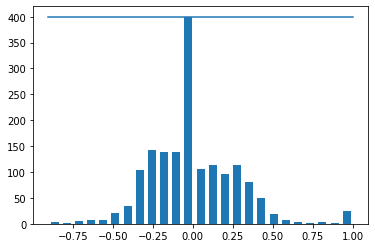

In [9]:
print('total data:', len(data))
# ctrl + / to comment a code
# for k in range(num_bins):
#  print('Set no: ', k)
#   print(data['steering'][k])
#   print(bins[k])
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]: #the steering angle in the range 0.96,0.97,0.95 would all belong to the same bin
      list_.append(i)
  list_ = shuffle(list_) #The above list is gonna contain all steering angles for a specific bin which are ordered in the manner the car was driven on the track. If we want to remove some set of data we need
  #make sure that the steering angles for the entire track is covered for which we use shuffle  
  list_ = list_[samples_per_bin:] #Isolate the list that goes beyond the threshold
  remove_list.extend(list_) #dispose the list by using extend which will allow to extend the list to what we wanna dispose right on to remove list
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True) #specific rows of data which correspond to the removed data list will be dropped by going to their data.index
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [10]:
print(data.iloc[1]) 
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i] #iloc allows to perform a selection on a row of data from our data frame based on the specified index(current indec iterating). index data will contain a specific row of data 
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2] #frim the row of data obtain center, left and right images
    image_path.append(os.path.join(datadir, center.strip())) #whule we place every center image onto this path, we are also going to be appending the main path from data dir. Strip will eliminate any spaces present in string
    steering.append(float(indexed_data[3])) #Append steering angles
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15) #adding or subtracting to include a more centered lane bias
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path) #convert to array for easier manipulation
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data) #track/IMG. This gives two arrays. one which is the image and the corresponding st angles which will be labels for these images

center      center_2019_12_22_06_44_16_719.jpg
left        left_2019_12_22_06_44_16_719.jpg  
right       right_2019_12_22_06_44_16_719.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.92e-05                          
Name: 13, dtype: object


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6) #split the image path and steering angle. Test size is the proportion of the current
#dataset to be included in the current valid. 
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid))) #the contents inside the format bracket will get populated within the curly braces in order

Training Samples: 3885
Valid Samples: 972


Text(0.5, 1.0, 'Validation set')

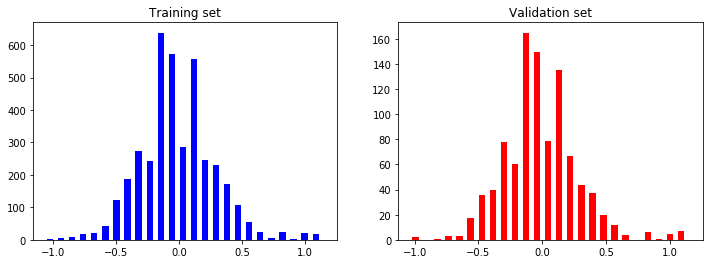

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# print(fig)
# print('axes',axes)
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image): 
  zoom = iaa.Affine(scale=(1, 1.3))  #Affine transformation preserves straight lines and planes within the objects. define a tuple of zoom range scale
  image = zoom.augment_image(image)
  return image

Text(0.5, 1, 'Zoomed Image')

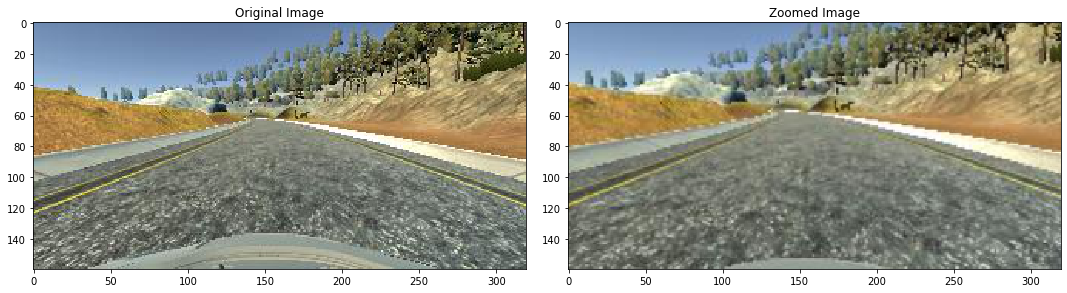

In [14]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image) #read the image path
zoomed_image = zoom(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)}) #horizontal(right to left) or vertical (up or down) translation of the image
  image = pan.augment_image(image)
  return image

Text(0.5, 1, 'Panned Image')

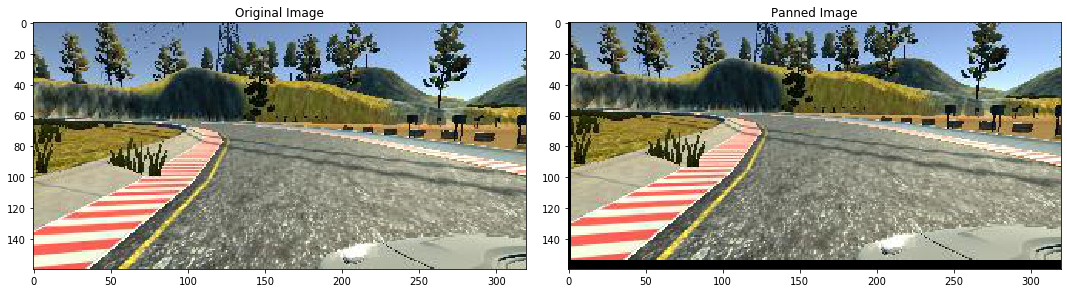

In [16]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2)) #multiply all the images with the value specified thus making the image darker if less than 1 or brighter if greater than 1
    image = brightness.augment_image(image)
    return image

Text(0.5, 1, 'Brightness altered image ')

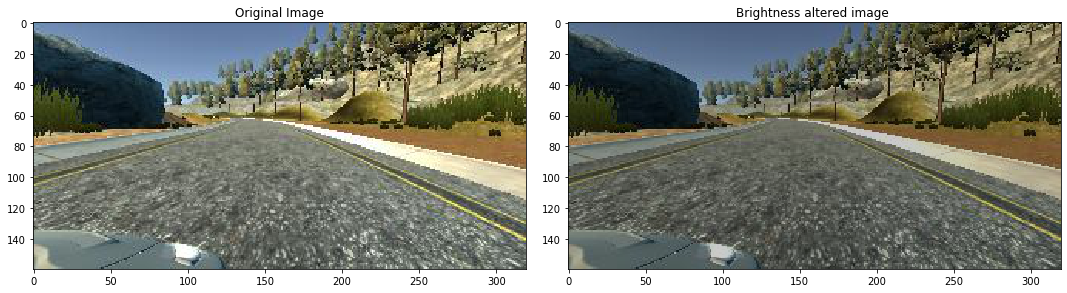

In [18]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [0]:
def img_random_flip(image, steering_angle): #randomly flip images to balance the dataset
    image = cv2.flip(image,1) #0 is vertical flip, 1 is horz, -1 is combination of both
    steering_angle = -steering_angle #also need to flip steering angle
    return image, steering_angle

Text(0.5, 1, 'Flipped Image - Steering Angle:0.10976880000000001')

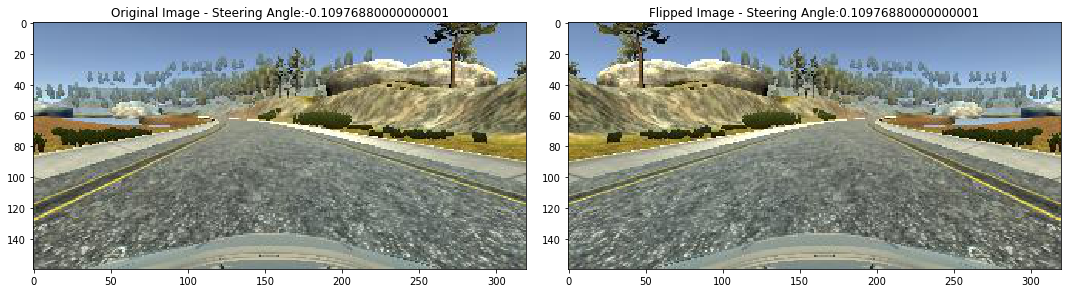

In [20]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle): #randomize all the images in the dataset so as to not perform all augmentations on a single image itself 
    image = mpimg.imread(image)
    if np.random.rand() < 0.5: #on avg each augmentation will only be done on 50% of newly augmented images
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

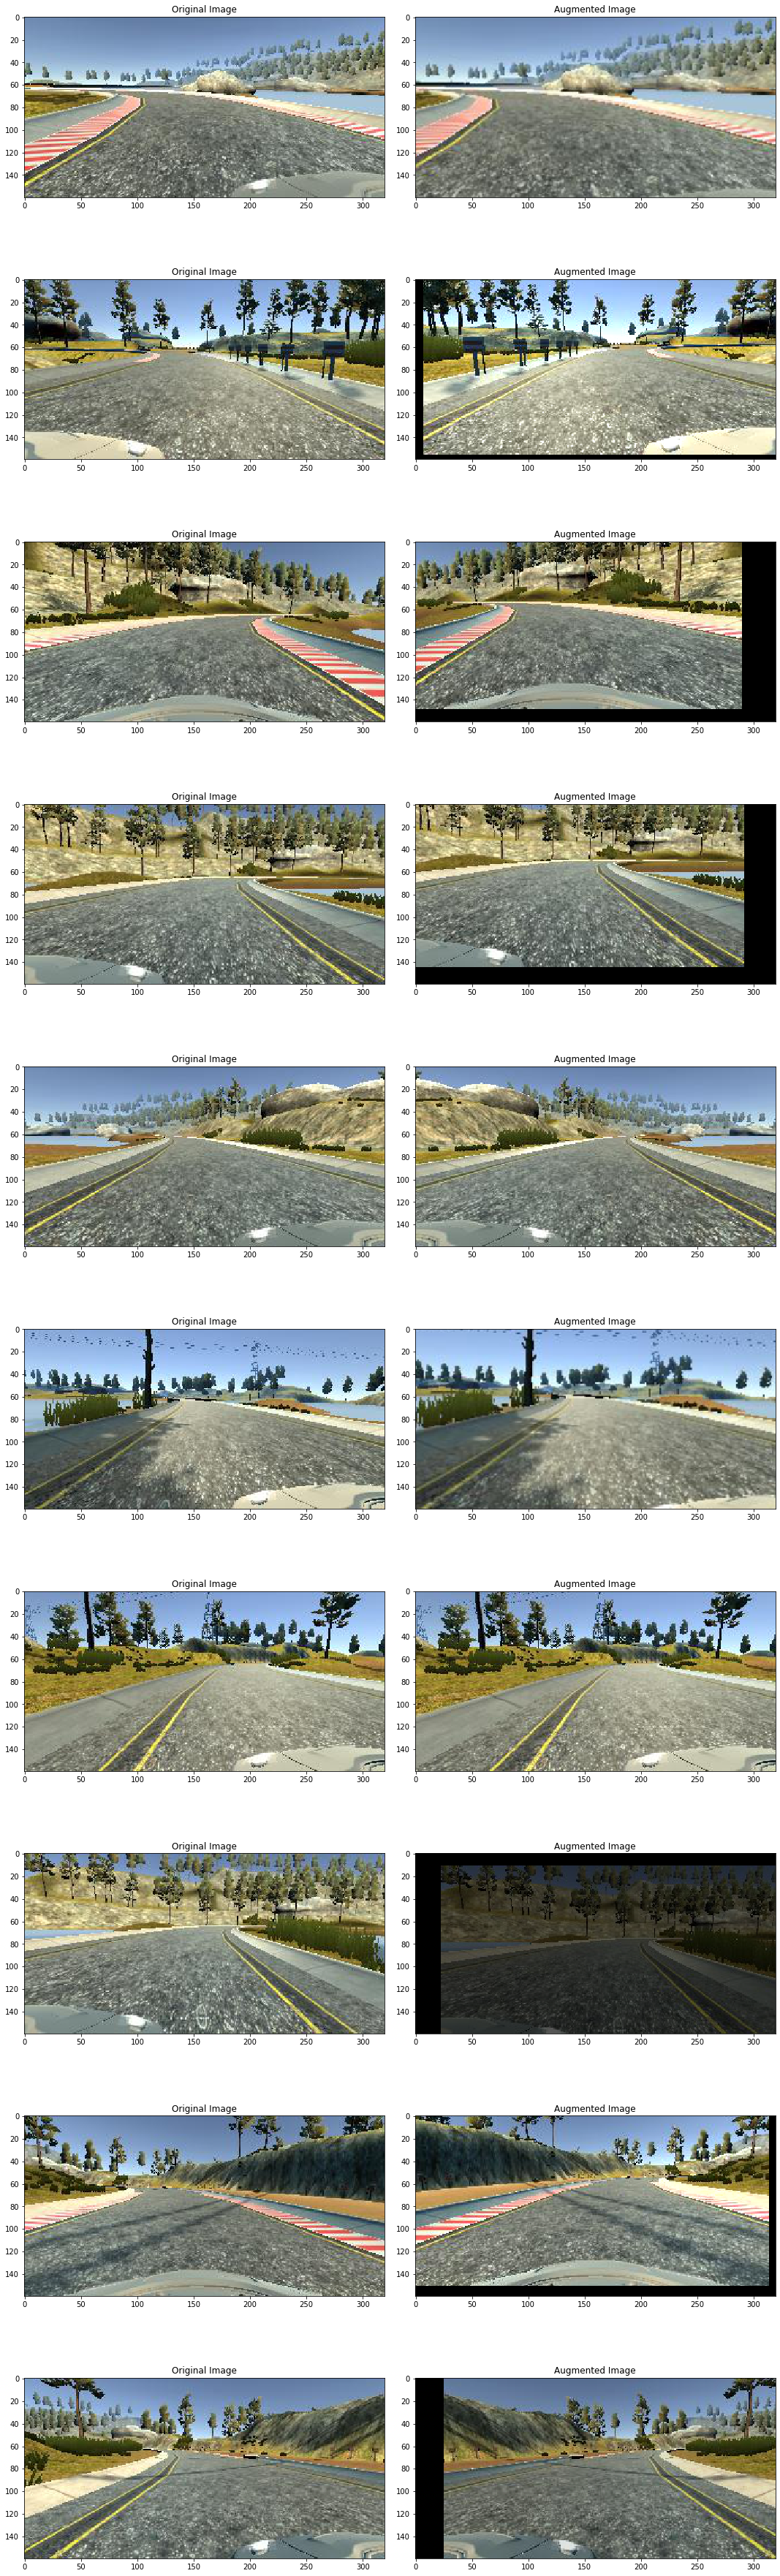

In [22]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [0]:
def img_preprocess(img):
    img = img[60:135,:,:] #crop unnecessary parts of the image like sky and some scenery
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #Convert the image from rgb to yuv
    img = cv2.GaussianBlur(img,  (3, 3), 0) #In terms of image processing, any sharp edges in images are smoothed while minimizing too much blurring. size is how much of the image gets blurred.
    img = cv2.resize(img, (200, 66)) #resize the pixels
    img = img/255 #normalize it
    return img

Text(0.5, 1, 'Preprocessed Image')

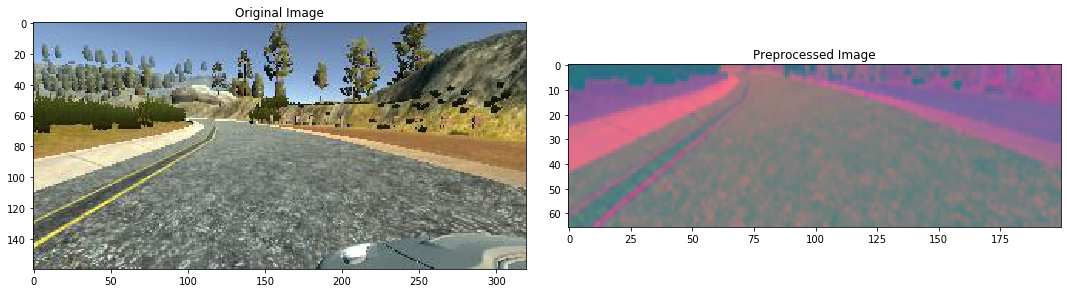

In [24]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
#the generator allows to create augmeneted images on the fly rather than augmenting and storing each image and then running the model. THis is memory efficient too. 
#Since fit() requires the entire dataset as a numpy array in memory, which is why for larger datasets we make use of fit_generator() to generate augmented images on the fly
#when needed and this is done in batches
def batch_generator(image_paths, steering_ang, batch_size, istraining): #the last argument is a boolean and returns true when the data being fed is only a training.
  
  while True: #A loop that will run indefinitely 
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else: #since validation data does not require any validation.
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  #the yield return keyword comes under the class of functions called co-routine since it stores all the 
    #intialised variables within the func as opposed to sub-routine type funct. When the func is called again it does not reinitialise instead builds up on the previous data.

Text(0.5, 1, 'Validation Image')

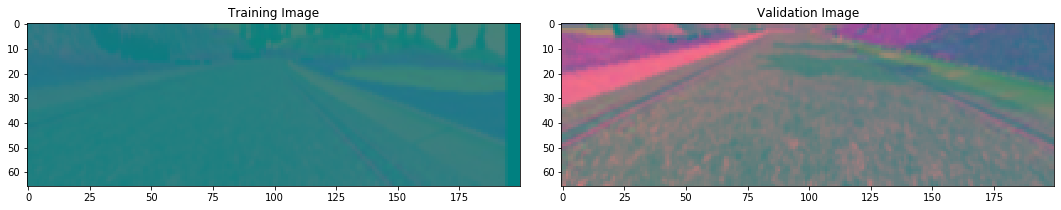

In [26]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1)) #1 image fed and second 1 is to say that the boolean value is true
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu')) #subsample refers to the stride length of the kernel as it processes through the sample of image. The kernel will translate 2 pixels horizontally and 2 pixels vertically
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu')) #not adding subsample because the image has become small enough
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))
# Using relu as an activation function leads to a phenomenon known as dead relu where a node basically dies and feeds a value of 0 to the node that follows it
# Relu returns 0 for all -ve values and the same value for the positive. The positive thus has a gradient whereas the negative value does not have any gradient which leads to
# the NN converting the value to 0 whenver it gets a -ve input and is thus unable to perform a gradient descent which will be used to minimize the error during backpropogation.
# Elu can be used which has a non-negative gradient descent and can return -ve values.  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5)) #these were removed since we are already doing various augmentation which solves the problem of over-fitting. Removing dropout also allows to eliminate the large 
#difference between training and validation loss.
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1)) #Output the predicted steering angle of the car
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [28]:
model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 120, 1),         #since the i/p images will  be created real time so we call the batch_gen.
                                  steps_per_epoch=300, 
                                  epochs=15,
                                  validation_data=batch_generator(X_valid, y_valid, 120, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)
#steps per epoch is the amount of steps that will be used per epoch. 





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act




Epoch 1/15





300/300 [==============================] - 215s 715ms/step - loss: 0.0801 - val_loss: 0.0574
Epoch 2/15
300/300 [==============================] - 201s 670ms/step - loss: 0.0696 - val_loss: 0.0577
Epoch 3/15
300/300 [==============================] - 203s 675ms/step - loss: 0.0659 - val_loss: 0.0515
Epoch 4/15
300/300 [==============================] - 204s 680ms/step - loss: 0.0608 - val_loss: 0.0575
Epoch 5/15
300/300 [==============================] - 200s 666ms/step - loss: 0.0574 - val_loss: 0.0499
Epoch 6/15
300/300 [==============================] - 200s 667ms/step - loss: 0.0565 - val_loss: 0.0465
Epoch 7/15
300/300 [==============================] - 202s 674ms/step - loss: 0.0536 - val_loss: 0.0410
Epoch 8/15
300/300 [==============================] - 203s 678ms/step - loss: 0.0514 - val_loss: 0.0357
Epoch 9/15
300/300 [==============================] - 201s 671ms/step - loss: 0.0490 - val_loss: 0.0330
Epoch 10/15
300/300 [==============================] - 2

Text(0.5, 0, 'Epoch')

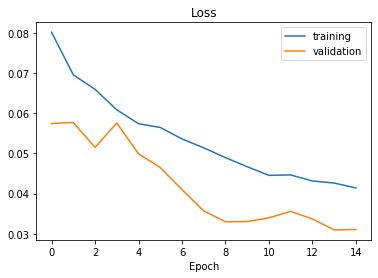

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')



In [0]:
model.save('model.h5') #THis will save the model 

In [0]:
from google.colab import files  
files.download('model.h5') #To download the model.h5 file